In [22]:
import numpy as np
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.metrics import mean_squared_error    
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import os
import matplotlib.pyplot as plt
from keras.utils import to_categorical

directory = 'Cleaned_CSV_files'
current_directory = os.getcwd()
csv_path = os.path.join(current_directory, directory, "EDA.csv")
df = pd.read_csv(csv_path, sep=',')

# Features auswählen
features = ['Einwohner_pro_Quadratkilometer','Einbruchdiebstahl_Total','Einschleichdiebstahl_Total']

total_crime = df['Einbruchdiebstahl_Total'] + df['Einschleichdiebstahl_Total']
df['Kriminalitätsrisiko'] = pd.cut(total_crime, bins=[-float("inf"), 100, 500, float("inf")], labels=["niedrig", "mittel", "hoch"])

print(df['Kriminalitätsrisiko'].value_counts())


Kriminalitätsrisiko
niedrig    1899
mittel      137
hoch         23
Name: count, dtype: int64


In [23]:

sequence_length = 3
sequences = []
targets = []

for i in range(len(df) - sequence_length):
    sequence = df[features].iloc[i:i+sequence_length].values
    target = df['Kriminalitätsrisiko'].iloc[i+sequence_length]
    sequences.append(sequence)
    targets.append(target)

# Feature-Skalierung für jede Dimension separat durchführen
scalers = [MinMaxScaler() for _ in range(len(features))]
sequences_scaled = []

for i, scaler in enumerate(scalers):
    feature_values = [sequence[:, i] for sequence in sequences]
    feature_values_scaled = scaler.fit_transform(feature_values)
    sequences_scaled.append(feature_values_scaled)

# Eingabe- und Ausgabedaten definieren
X = np.array(sequences_scaled).transpose(1, 2, 0)
y = np.array(targets)

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Einfaches RNN-Modell definieren
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)  # Output Layer für die Vorhersage
])

# Label Encoder erstellen
label_encoder = LabelEncoder()

# Kategorische Labels in numerische Werte umwandeln
y_train_encoded = label_encoder.fit_transform(y_train)

# Einfaches RNN-Modell definieren
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])

# Modell kompilieren
model.compile(optimizer='adam', loss='mse')  # Mean Squared Error als Verlustfunktion

# Modell trainieren
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2)#

# Label Encoder erstellen
label_encoder = LabelEncoder()

# Zielvariablen in numerische Werte umwandeln
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Konvertieren der Zielvariablen in kategorische Variablen
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Modellvorhersagen machen
predictions = model.predict(X_test)

# Konvertieren der kategorischen Labels in y_test in numerische Werte
y_test_numeric = label_encoder.transform(y_test)

test_loss = model.evaluate(X_test, y_test_categorical)

print("Test Loss:", test_loss)

# Berechnen der Genauigkeit
accuracy = np.sum(np.argmax(predictions, axis=1) == y_test_numeric) / len(y_test_numeric)
print("Test Accuracy:", accuracy)

# Berechnen des Mean Squared Error (MSE)
mse = mean_squared_error(y_test_numeric, predictions)
print("Mean Squared Error (MSE):", mse)


Epoch 1/10
42/42 [==============================] - 0s 3ms/step - loss: 1.5229 - val_loss: 0.3943
Epoch 2/10
42/42 [==============================] - 0s 852us/step - loss: 0.1692 - val_loss: 0.0660
Epoch 3/10
42/42 [==============================] - 0s 816us/step - loss: 0.0746 - val_loss: 0.0668
Epoch 4/10
42/42 [==============================] - 0s 807us/step - loss: 0.0747 - val_loss: 0.0677
Epoch 5/10
42/42 [==============================] - 0s 806us/step - loss: 0.0751 - val_loss: 0.0666
Epoch 6/10
42/42 [==============================] - 0s 792us/step - loss: 0.0724 - val_loss: 0.0661
Epoch 7/10
42/42 [==============================] - 0s 806us/step - loss: 0.0726 - val_loss: 0.0649
Epoch 8/10
42/42 [==============================] - 0s 803us/step - loss: 0.0715 - val_loss: 0.0725
Epoch 9/10
42/42 [==============================] - 0s 791us/step - loss: 0.0727 - val_loss: 0.0650
Epoch 10/10
13/13 [==============================] - 0s 462us/step - loss: 2.8332
Test Loss: 2.8331546

Ein niedrigerer Loss-Wert deutet darauf hin, dass das Modell besser in der Lage ist, die Testdaten vorherzusagen. In diesem Fall ist der Loss-Wert jedoch relativ hoch, was darauf hinweisen könnte, dass das Modell nicht so gut auf die Testdaten generalisiert, wie es auf den Trainingsdaten der Fall ist.

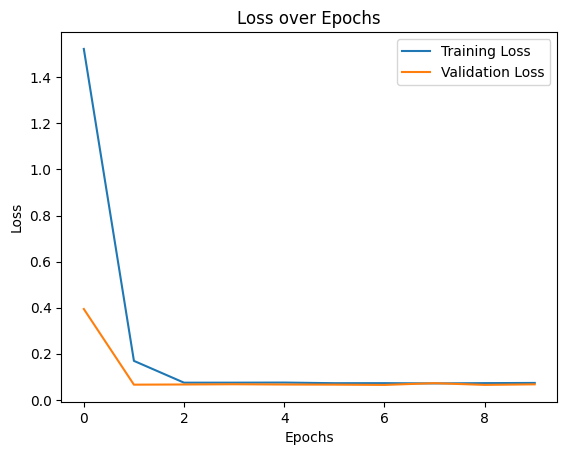

In [30]:

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [25]:
# Definieren der Schwellenwerte für die absolute Anzahl der Verbrechen
thresholds = [50, 500]

def label_absolute_crime_rate(crime_count):
    if crime_count < thresholds[0]:
        return "niedrig"
    elif thresholds[0] <= crime_count < thresholds[1]:
        return "mittel"
    else:
        return "hoch"

df['Absolute_Kriminalitätsrate'] = df['Einbruchdiebstahl_Total'] + df['Einschleichdiebstahl_Total']
df['Absolute_Kriminalitätsrate'] = df['Absolute_Kriminalitätsrate'].apply(label_absolute_crime_rate)

print(df['Absolute_Kriminalitätsrate'].value_counts())


Absolute_Kriminalitätsrate
niedrig    1663
mittel      373
hoch         23
Name: count, dtype: int64


In [26]:

features = ['Einwohner_pro_Quadratkilometer', 'Einbruchdiebstahl_Total', 'Einschleichdiebstahl_Total']

sequence_length = 3
sequences = []
targets = []

for i in range(len(df) - sequence_length):
    sequence = df[features].iloc[i:i+sequence_length].values
    target = df['Absolute_Kriminalitätsrate'].iloc[i+sequence_length]
    sequences.append(sequence)
    targets.append(target)

# Feature-Skalierung für jede Dimension separat durchführen
scalers = [MinMaxScaler() for _ in range(len(features))]
sequences_scaled = []

for i, scaler in enumerate(scalers):
    feature_values = [sequence[:, i] for sequence in sequences]
    feature_values_scaled = scaler.fit_transform(feature_values)
    sequences_scaled.append(feature_values_scaled)

# Eingabe- und Ausgabedaten definieren
X = np.array(sequences_scaled).transpose(1, 2, 0)
y = np.array(targets)

# Aufteilung der Daten in Trainings- und Testsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label Encoder erstellen
label_encoder = LabelEncoder()

# Zielvariablen in numerische Werte umwandeln
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Konvertieren der Zielvariablen in kategorische Variablen
y_train_categorical = to_categorical(y_train_encoded)
y_test_categorical = to_categorical(y_test_encoded)

# Einfaches RNN-Modell definieren
model = Sequential([
    SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(3, activation='softmax')  # Output Layer für die Vorhersage mit Softmax-Aktivierungsfunktion
])

# Modell kompilieren
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  

# Modell trainieren
history2 = model.fit(X_train, y_train_categorical, epochs=10, batch_size=32, validation_split=0.2)




Epoch 1/10
42/42 [==============================] - 0s 3ms/step - loss: 0.7766 - accuracy: 0.7871 - val_loss: 0.5866 - val_accuracy: 0.8024
Epoch 2/10
42/42 [==============================] - 0s 886us/step - loss: 0.5317 - accuracy: 0.8068 - val_loss: 0.4850 - val_accuracy: 0.8024
Epoch 3/10
42/42 [==============================] - 0s 841us/step - loss: 0.4780 - accuracy: 0.8144 - val_loss: 0.4609 - val_accuracy: 0.8267
Epoch 4/10
42/42 [==============================] - 0s 829us/step - loss: 0.4741 - accuracy: 0.8152 - val_loss: 0.4580 - val_accuracy: 0.8298
Epoch 5/10
42/42 [==============================] - 0s 799us/step - loss: 0.4689 - accuracy: 0.8144 - val_loss: 0.4509 - val_accuracy: 0.8237
Epoch 6/10
42/42 [==============================] - 0s 803us/step - loss: 0.4638 - accuracy: 0.8160 - val_loss: 0.4497 - val_accuracy: 0.8207
Epoch 7/10
42/42 [==============================] - 0s 820us/step - loss: 0.4572 - accuracy: 0.8205 - val_loss: 0.4473 - val_accuracy: 0.8359
Epoch 8/

In [27]:
# Modell evaluieren
test_loss = model.evaluate(X_test, y_test_categorical)
predictions = model.predict(X_test)

print("Test Loss:", test_loss)
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_categorical, axis=1)) / len(y_test_categorical)
print("Test Accuracy:", accuracy)
mse = np.mean((np.argmax(predictions, axis=1) - np.argmax(y_test_categorical, axis=1))**2)
print("Mean Squared Error (MSE):", mse)


13/13 [==============================] - 0s 446us/step
Test Loss: [0.41630569100379944, 0.8349514603614807]
Test Accuracy: 0.8349514563106796
Mean Squared Error (MSE): 0.1650485436893204


Das Modell erreichte eine Testgenauigkeit von etwa 83.50% und einen mittleren quadratischen Fehler (MSE) von etwa 0.165.
Die Testgenauigkeit ist hoch, und der MSE ist vergleichsweise niedrig, was darauf hinweist, dass das Modell gute Vorhersagen trifft und die Abweichung zwischen den Vorhersagen und den tatsächlichen Werten gering ist.

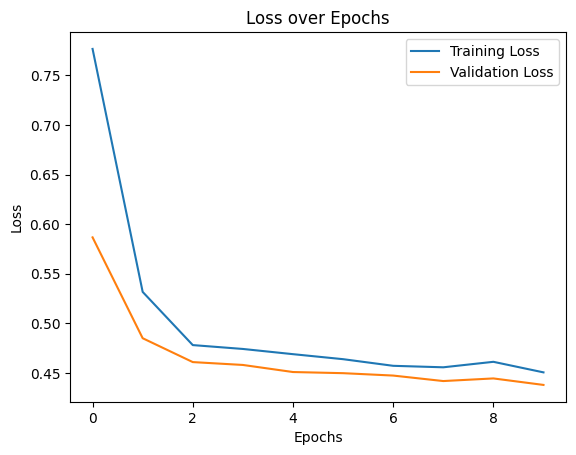

In [28]:

plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Kategorische Risikoraten (niedrig, mittel, hoch):
Das Modell erreichte eine Testgenauigkeit von etwa 0.49% und einen mittleren quadratischen Fehler (MSE) von etwa 0.076. Die Testgenauigkeit ist sehr niedrig, und der MSE ist relativ hoch, was darauf hinweist, dass das Modell Schwierigkeiten hat, genaue Vorhersagen zu treffen.

Absolute Kriminalitätsraten:
Das Modell erreichte eine Testgenauigkeit von etwa 83.50% und einen MSE von etwa 0.165.
Die Testgenauigkeit ist hoch, und der MSE ist niedriger im Vergleich zum ersten Modell, was darauf hindeutet, dass dieses Modell besser in der Lage ist, genaue Vorhersagen zu treffen.

Höhere Informationsdichte: Bei der Verwendung der absoluten Kriminalitätsrate als Zielvariable gibt es eine höhere Informationsdichte, da jede Beobachtung einen spezifischen numerischen Wert hat. Dies ermöglicht es dem Modell, feinere Unterschiede zwischen den Datenpunkten zu erfassen und genauere Vorhersagen zu treffen.

Bessere Passung der Modellkomplexität: Wenn die Zielvariable kontinuierlich ist, kann das Modell besser auf die Daten passen, insbesondere wenn die tatsächlichen Beziehungen zwischen den Eingangsvariablen und der Zielvariable kontinuierlich sind. Kategorische Variablen können die Komplexität des Modells erhöhen, da das Modell versuchen muss, diskrete Kategorien zuzuordnen, was zu einem erhöhten Generalisierungsfehler führen kann.

Vermeidung von Informationsverlust: Bei der Kategorisierung der Kriminalitätsrate gehen möglicherweise Informationen verloren, da die Kontinuität der Daten nicht vollständig berücksichtigt wird. Dies kann zu einem Informationsverlust führen, der sich negativ auf die Leistung des Modells auswirken kann.